Get started with required imports:

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import requests, os, time

from dotenv import load_dotenv

Load API key from .env and run a sanity check to confirm value is present.

In [2]:
API_KEY = os.getenv("NPS_API_KEY")

print(API_KEY is not None)

True


In [3]:
df = pd.ExcelFile(r"../data/NPS-Mortality-Data-CY2007-to-CY2024-Released-August-2024.xlsx")
df = df.parse(sheet_name="CY2007-Present Q2")
df.head()

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Outcome,Sex,Age Range,Activity
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,65+,Not Reported
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Drowning,Unintentional,Fatal injury,Male,Not Reported,Vessel Related
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,Not Reported,Vessel Related
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,15-24,Driving
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,45-54,Driving


Use .info() to get a look at the column names, datatypes, and counts.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 9 columns):
 #   Column                                                        Non-Null Count  Dtype         
---  ------                                                        --------------  -----         
 0   Incident Date                                                 4635 non-null   datetime64[ns]
 1   Park Name                                                     4635 non-null   object        
 2   Cause of Death                                                4635 non-null   object        
 3   Cause of Death Group 
(Used in the NPS Mortality Dashboard)   4635 non-null   object        
 4   Intent                                                        4635 non-null   object        
 5   Outcome                                                       4635 non-null   object        
 6   Sex                                                           4635 non-null   object        
 7   Age Ran

Print a list of the columns that may be easier to reference.

In [5]:
print(df.columns)

Index(['Incident Date', 'Park Name', 'Cause of Death',
       'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ',
       'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity'],
      dtype='object')


I'm going to look more closely at the "Cause of death" and "Cause of Death Group \n..." columns to see if this data is redundant, or if I need to use both in my analysis.

Check if all values in all rows and columns are the same.

In [6]:
(df["Cause of Death"] == df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]).all()

np.False_

Since the are not duplicates, I'm going to build a mask to count how many mismatches are in the data.

In [7]:
mask_mismatch = df["Cause of Death"] != df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]
print("Total rows:", len(df))
print(mask_mismatch.sum())

Total rows: 4635
494


I'm going to look at some of the mismatches to see what the differences are.

In [8]:
df.loc[mask_mismatch, ["Cause of Death", "Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]].head(20)

,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard)
8,Avalanche,Environmental
9,Vessel Incident,Other Transportation
46,Vessel Incident,Other Transportation
48,Bicycle only crash,Other Transportation
56,Poisoning - Drugs,Poisoning
65,Poisoning - Drugs,Poisoning
76,Poisoning - Carbon monoxide,Poisoning
90,Hypothermia,Environmental
97,Firearm,Other
112,Bicycle only crash,Other Transportation


It seems like I will be able to use the "Cause of Death" column and ignore the group column in my analysis. I'm going to look more closely at the cause of death column now.

In [9]:
df.groupby("Cause of Death").size()

Cause of Death
Aircraft Incident                          31
Aircraft incident                          46
Altitude                                    1
Asphyxiation                                7
Avalanche                                  41
Bicycle only crash                         23
Collapsing earth/sand                       2
Drowning                                  864
Electrocution                               4
Fall                                      505
Falling Ice                                 2
Falling tree/branch                        21
Fire/Burn                                   3
Fire/burn                                   2
Firearm                                     5
Flash flood                                14
Homicide                                   51
Horseback riding Incident                   1
Horseback riding incident                   3
Hyperthermia                               83
Hypothermia                                46
Legal Intervention 

There are some obvious duplicates in that list, so I'm going to normalize the causes to try to catch duplicates.

In [10]:
df["Cause of Death"] = df["Cause of Death"].str.strip().str.lower()

I want to see how many unique values I have now.

In [11]:
df["Cause of Death"].nunique()

42

I'm going to look at a list of the unique values just to see what I have since there aren't that many.

In [12]:
print(sorted(df["Cause of Death"].unique()))

['aircraft incident', 'altitude', 'asphyxiation', 'avalanche', 'bicycle only crash', 'collapsing earth/sand', 'drowning', 'electrocution', 'fall', 'falling ice', 'falling tree/branch', 'fire/burn', 'firearm', 'flash flood', 'homicide', 'horseback riding incident', 'hyperthermia', 'hypothermia', 'legal intervention', 'lightning strike', 'medical - during physical activity', 'medical - not during physical activity', 'medical - unknown', 'motor vehicle crash', 'other', 'poisoning - alcohol', 'poisoning - carbon monoxide', 'poisoning - drugs', 'poisoning - other', 'rockfall', 'skateboard incident', 'skiing incident', 'snowboard incident', 'snowmobile incident', 'struck by/against', 'suicide', 'train crash', 'trolly crash', 'undetermined', 'vessel incident', 'water diving incident', 'widlife incident']


Looking over the columns, I don't see any duplicates or names that should be changed right now. I'm going to change them back to have an uppercase character.

In [13]:
df["Cause of Death"] = df["Cause of Death"].str.title()
print(df["Cause of Death"])

0              Undetermined
1                  Drowning
2              Undetermined
3       Motor Vehicle Crash
4       Motor Vehicle Crash
               ...         
4630    Motor Vehicle Crash
4631    Motor Vehicle Crash
4632                Suicide
4633           Undetermined
4634           Undetermined
Name: Cause of Death, Length: 4635, dtype: object


Now that I know what column to use and I have eliminated case mismatches, I'm going to build a plot to just look at the causes of death.

I want to show the major causes of death. This will calculate the percentage of deaths attributed to each cause, and also group causes accounting for <5% of deaths be combined into an "other" category to avoid cluttering the plot. The variables defined here will be used in the plot.

In [14]:
cause_counts = df["Cause of Death"].value_counts(dropna=False)
percentages  = cause_counts / cause_counts.sum() * 100

major_causes = percentages[percentages >= 5].copy()
other_total  = percentages[percentages < 5].sum()
if other_total > 0:
    major_causes.loc["Other"] = other_total

I'm going to define my color palette to be used with this plot. I'm also going to set the colors up be the same for both medical cause deaths.

In [15]:
okabe_ito = [
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#F0E442",
    "#0072B2",
    "#D55E00",
    "#CC79A7", 
]
OTHER_GREY = "#9e9e9e"

def color_for_label(lbl):
    s = str(lbl).strip().lower()
    if s == "other":
        return OTHER_GREY

    if "medical" in s:
        return "#E69F00"  # orange
    return None



Now that the colors are defined, I'll build a for loop to cycle through the unused options.

In [16]:
used = {c for c in [color_for_label(x) for x in major_causes.index] if c}
remaining = [c for c in okabe_ito if c not in used]
colors = []
idx = 0
for lbl in major_causes.index:
    c = color_for_label(lbl)
    if c is None:
        c = remaining[idx % len(remaining)]
        idx += 1
    colors.append(c)

Now I'm going to create a pie chart that shows the major causes of death.

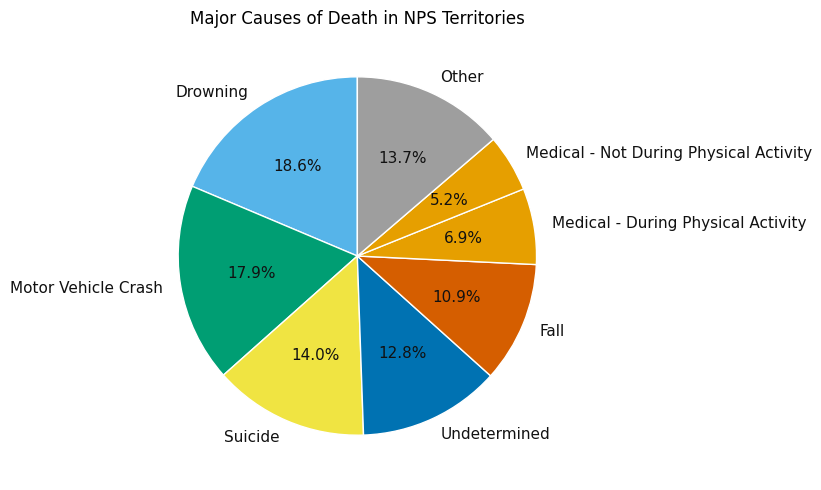

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    major_causes.values,
    labels=major_causes.index,
    colors=colors,
    autopct="%1.1f%%",
    wedgeprops={"linewidth": 1.0, "edgecolor": "white"},
    startangle=90
)
for t in texts:
    t.set_color("#111111")
    t.set_fontsize(11)

for t in autotexts:
    t.set_fontsize(11)
    t.set_color("#111111")
  

ax.set_title("Major Causes of Death in NPS Territories")

plt.tight_layout()
plt.show()


Drowning is the most frequent cause of death, so I'm going to look at that more closely to see if there are any common threads. I'm going to look at the number of drownings in each territory/park to see if there are any outliers. First, I'm going to normalize the park names to check for any case mismatches.

I know that I want to use data from other NPS datasets along with this information. I also know that there are 3 major sources (NPS Mortality Dataset, IRMA API, and NPS Data API) and the park name is inconsistent across all 3. The API datasets both use a 4 letter code that is  consistent. I'm going to use one of the APIs to match the names of the parks in the mortality dataset to the appropriate park code so that I may query either database for info with the 4 letter code.